# Sentiment análisis

**Objetivo**: a partir de los datasets con textos y los sentiment_values conocidos, hacer análisis de sentimiento con un método de lexicon (VADER) y chequear las métricas. Luego, hacer un análisis de sentimiento con algunos modelos de ML usando embeddings. Finalmente, comparar los resultados.

In [277]:
import string
import nltk
from nltk.corpus import stopwords
import gensim as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import regex as re
#from sentence_transformers import SentenceTransformer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## 1 - Get text

In [13]:
df = pd.read_csv("dataset/amazon_cells_labelled.txt",delimiter='\t',header=None)
df.columns = ['text','sentiment_value']
df.head()

,text,sentiment_value
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             1000 non-null   object
 1   sentiment_value  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [15]:
X = df.text
Y = df.sentiment_value

Entonces la idea sería hacer un sentiment analysis de los x=texts y midiendo las metricas contra los y=sentiment_values.

## 2 - Sentiment analisis: Lexicon method (rule-based)

El método está basado en reglas, dando puntajes positivos o negativos en función de las palabras y símbolos utilizados en el texto.

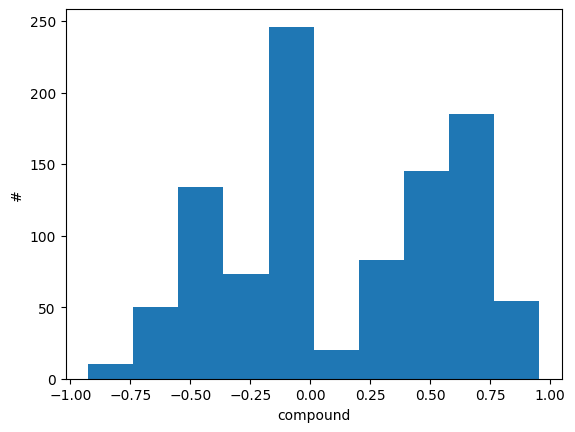

In [306]:
VADER = SentimentIntensityAnalyzer()

y_vader = []
for i,text in enumerate(X):
    comp = VADER.polarity_scores(text.lower())['compound']
    if comp>0.0:
        y_vader.append([comp,1])
    else:
        y_vader.append([comp,0])
        
y_vader = pd.DataFrame(y_vader,columns=['comp','y'])
plt.hist(y_vader.comp)
#plt.xticks([-1,0,1])
plt.ylabel('#')
plt.xlabel('compound')
plt.show()

In [307]:
for i,text in enumerate(X[:10]):
    print(text)
    print('comp = ',y_vader.comp[i])
    print('y_vader = y_real :  ',y_vader.y[i] == Y[i])
    print('---')

So there is no way for me to plug it in here in the US unless I go by a converter.
comp =  -0.3535
y_vader = y_real :   True
---
Good case, Excellent value.
comp =  0.8402
y_vader = y_real :   True
---
Great for the jawbone.
comp =  0.6249
y_vader = y_real :   True
---
Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!
comp =  -0.508
y_vader = y_real :   True
---
The mic is great.
comp =  0.6249
y_vader = y_real :   True
---
I have to jiggle the plug to get it to line up right to get decent volume.
comp =  0.0
y_vader = y_real :   True
---
If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.
comp =  0.5106
y_vader = y_real :   False
---
If you are Razr owner...you must have this!
comp =  0.0
y_vader = y_real :   False
---
Needless to say, I wasted my money.
comp =  -0.4939
y_vader = y_real :   True
---
What a waste of money and time!.
comp =  -0.4753
y_vader = y_real :   True
---


Aunque en algunos casos se logra predecir correctamente el sentimiento, en otros casos no, principalmente cuando hay frases ambigüas o irónicas.

In [308]:
# Métricas de error:
print('scores:')
print('accuracy = ',skl.metrics.accuracy_score(y_vader.y,Y))
print('recall = ',skl.metrics.recall_score(y_vader.y,Y).round(4))
print('F1 = ',skl.metrics.f1_score(y_vader.y,Y).round(4))

scores:
accuracy =  0.835
recall =  0.8439
F1 =  0.8328


Veamos si se observa alguna mejora al realizar una limpieza de los datos.

In [309]:
# remove puntuation, links, etc...
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower() #lowercase
    text = re.sub('\[.*?\]', '', text) #text between []
    text = re.sub('https?://\S+|www\.\S+', '', text) # web links
    text = re.sub('<.*?>+', '', text) # text between <>
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #punctiation
    text = re.sub('\n', '', text) #\n
    text = re.sub('\w*\d\w*', '', text)
    return text

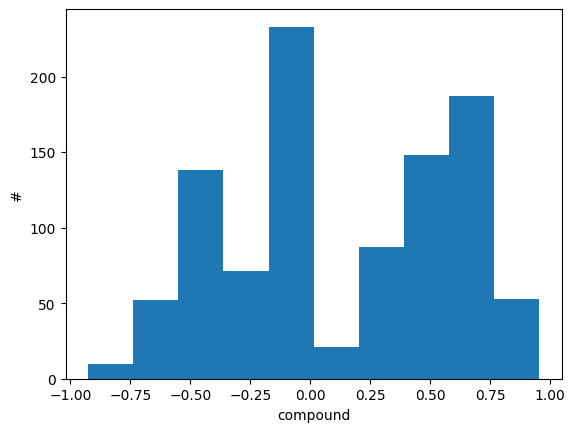

In [310]:
VADER = SentimentIntensityAnalyzer()

y_vader = []
for i,text in enumerate(X):
    comp = VADER.polarity_scores(clean_text(text))['compound']
    if comp>0.0:
        y_vader.append([comp,1])
    else:
        y_vader.append([comp,0])
        
y_vader = pd.DataFrame(y_vader,columns=['comp','y'])
plt.hist(y_vader.comp)
#plt.xticks([-1,0,1])
plt.ylabel('#')
plt.xlabel('compound')
plt.show()

In [311]:
# Métricas de error:
print('scores:')
print('accuracy = ',skl.metrics.accuracy_score(y_vader.y,Y))
print('precision = ',skl.metrics.precision_score(y_vader.y,Y).round(4))
print('recall = ',skl.metrics.recall_score(y_vader.y,Y).round(4))

scores:
accuracy =  0.841
precision =  0.838
recall =  0.8431


Las métricas son similares.

## 3 - Sentiment analisis: ML model con Glove (word enbedding)

Para empezar voy a hacer separar un conjunto de datos de testing para poder evaluar después el modelo.

In [313]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, Y, test_size = 0.2, random_state=0)

* Genero los embeddings para cada texto:

In [314]:
language = 'english'
stop_words = stopwords.words(language) #stopwords
lemmatizer = nltk.stem.WordNetLemmatizer() #Lemmatization

def preprocess_text(text):
    # Clean
    text = clean_text(text)
    # Remove stopwords and lemmatize
    tokens = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return tokens

In [121]:
# Load Glove local
path = 'C:/Users/Lucas/gensim-data/glove-twitter-50/glove-twitter-50.gz'
model_emb = gs.models.KeyedVectors.load_word2vec_format(path)

In [315]:
# sentence to vector
def sent2vec(sent):
    sent_pp = preprocess_text(sent)
    tokens = str(sent_pp).split()

    vec = model_emb.get_vector('king')*0
    for token in tokens:
        try:
            vec = vec + model_emb.get_vector(token)     
        except:
            continue
    vec = np.array(vec)
    if np.sqrt((vec ** 2).sum()) ==0: 
        vec = vec*0
        print(tokens,'vec=0')
    else: vec = vec / np.sqrt((vec ** 2).sum())
    return vec

In [316]:
X_train_emb = np.array([sent2vec(sent) for sent in X_train])
X_test_emb = np.array([sent2vec(sent) for sent in X_test])

['windresistant'] vec=0
['satisifed'] vec=0


In [317]:
X_train_emb.shape

(800, 50)

* Entreno un modelo de ML de regresión logística

In [179]:
model = skl.linear_model.LogisticRegression()
CV_results = skl.model_selection.cross_validate(model, X_train_emb, y_train, cv=10, scoring='accuracy',return_train_score=True)

In [180]:
print('test_accuracy = ', CV_results['test_score'].mean())
print('train_accuracy = ', CV_results['train_score'].mean())

test_accuracy =  0.7775000000000001
train_accuracy =  0.7919444444444445


* Entreno un modelo de ML de SVM

In [251]:
model = skl.svm.SVC()
parameters = {'C':[0.01, 0.1, 1.0], 'kernel':['linear', 'poly', 'rbf']}
GSCV_results = GridSearchCV(model, parameters, scoring='accuracy',cv=5)
GSCV_results.fit(X_train_emb, y_train)
GSCV_results.best_score_

0.78625

In [252]:
GSCV_results.best_estimator_

SVC(kernel='poly')

In [253]:
model = skl.svm.SVC(kernel='linear')
CV_results = skl.model_selection.cross_validate(model, X_train_emb, y_train, cv=10, scoring='accuracy',return_train_score=True)
print('test_accuracy = ', CV_results['test_score'].mean())
print('train_accuracy = ', CV_results['train_score'].mean())

test_accuracy =  0.7787499999999999
train_accuracy =  0.8033333333333333


* Entreno un modelo de ML de random forest

In [238]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
model = RandomForestClassifier()
parameters = {'max_depth':[5,10,20], 'min_samples_leaf':[5,7,10]}
GSCV_results = GridSearchCV(model, parameters,scoring='accuracy',cv=5)
GSCV_results.fit(X_train_emb, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [5, 7, 10]},
             scoring='accuracy')

In [239]:
GSCV_results.best_score_

0.77375

In [240]:
GSCV_results.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=10)

In [259]:
model = RandomForestClassifier(max_depth=10,min_samples_leaf=10)
CV_results = skl.model_selection.cross_validate(model, X_train_emb, y_train, cv=10, scoring='accuracy',return_train_score=True)
print('validation_accuracy = ', CV_results['test_score'].mean())
print('train_accuracy = ', CV_results['train_score'].mean())

validation_accuracy =  0.7725
train_accuracy =  0.9244444444444444


El accuracy de entrenamiento es mucho mayor que el de validación, lo que es un indicio de sobreajuste.

No se ven mejoras significativas entre los modelos. Ninguno da mejores resultados que Vader solo.

Uso los resultados de VADER como variables de entrada para ver si me permite mejorar las predicciones.

* Modelo SVM con Vader

In [318]:
VADER = SentimentIntensityAnalyzer()
y_vader_train = []
for i,text in enumerate(X_train):
    y_vader_train.append(VADER.polarity_scores(clean_text(text))['compound'])
y_vader_train = np.array(y_vader_train)
y_vader_train.shape

(800,)

In [319]:
X_train_emb_pvader = np.append(X_train_emb,y_vader_train.reshape(-1,1),axis=1)
X_train_emb_pvader.shape

(800, 51)

In [320]:
model = skl.svm.SVC(kernel='linear')
CV_results = skl.model_selection.cross_validate(model, X_train_emb_pvader, y_train, cv=10, scoring='accuracy',return_train_score=True)
print('test_accuracy = ', CV_results['test_score'].mean())
print('train_accuracy = ', CV_results['train_score'].mean())

test_accuracy =  0.85125
train_accuracy =  0.8633333333333335


El error algo mayor, pero muy poco, respecto al de VADER. Chequeo el error de testing.

In [321]:
VADER = SentimentIntensityAnalyzer()
y_vader_test = []
for i,text in enumerate(X_test):
    y_vader_test.append(VADER.polarity_scores(clean_text(text))['compound'])
y_vader_test = np.array(y_vader_test)
y_vader_test.shape

(200,)

In [322]:
X_test_emb_pvader = np.append(X_test_emb,y_vader_test.reshape(-1,1),axis=1)
X_test_emb_pvader.shape

(200, 51)

In [323]:
model = skl.svm.SVC(kernel='linear').fit(X_train_emb_pvader, y_train)

In [324]:
model.score(X_test_emb_pvader, y_test)

0.85

## Conclusiones:

* Se implementó un sentiment analysis del dataset, comenzando con VADER (rule-based method), y se calcularon las métricas de predicción.
* Se usó el modelo de embeddings de Glove para pasar los textos a vectores.
* Usando los embeddings de cada texto, se implementaron varios modelos de ML, encontrando que las métricas no logran superar las del método VADER.
* Finalmente se usaron los resultados del método VADER como variable de entrada de un modelo de ML de SVC, logrando que la métrica sea algo mejor a la de VADER, aunque la diferencia es mínima.

Discusión:
* Posiblemente el modelo Glove de embeddings no sea muy bueno para la clasificación de sentimientos, por lo que podría mejorarse usando un modelo de sentence-embeddings.
* Se podría implementar un modelo de reducción dimensional (PCA, LDA) en una etapa previa al modelo de ML.